# Decision Tree (tau) [vif5]
This is a simple, yet powerful algorithm that can be used for both regression and classification problems. It works well with categorical data, as well as data with non-linear relationships.

https://scikit-learn.org/stable/modules/tree.html#regression

tree.DecisionTreeRegressor()

{'ccp_alpha': 0.0,   
 'criterion': 'squared_error',   
 'max_depth': None,   
 'max_features': None,   
 'max_leaf_nodes': None,   
 'min_impurity_decrease': 0.0,   
 'min_samples_leaf': 1,   
 'min_samples_split': 2,   
 'min_weight_fraction_leaf': 0.0,   
 'random_state': None,   
 'splitter': 'best'}   
 
**_bayesian hyperparameter tuning_**

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import platform
import seaborn as sns
from sklearn import linear_model
from sklearn import tree
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize, space
from skopt.space import Real, Integer
import sys

from validation import cross_validation
from validation import performance_test_shifted

date_format = '%Y-%m-%d'

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

In [2]:
# config 'all', 'vif_5' or 'vif_10'
vif = 'vif_5'

# config model
ml_algorithm = tree.DecisionTreeRegressor
filename = 'single-model_tau_dt'

In [3]:
my_os = platform.system()
print('OS in my system: ',my_os)

if my_os == 'Windows':
    path = str(pathlib.Path().absolute()) + '\\'
    slash = '\\'
else:
    path = str(pathlib.Path().absolute()) + '/'
    slash = '/'

path_3 = path.replace('4_modelling', '3_data_pre-processing')

OS in my system:  Linux


## Load Data

In [4]:
data_set = pd.read_csv(path_3 + 'data_artifacts' + slash + 'data_set_e_spx_3-' + vif + '.csv', index_col=0)

## Original Target Model (no forecast horizon)
### Time Series Cross Validation on Default Model

In [5]:
default_model = ml_algorithm(random_state=23)
default_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 23,
 'splitter': 'best'}

In [6]:
default_model_scores_ori = cross_validation (data_set, default_model, 'tau_target_ori')
pd.DataFrame(default_model_scores_ori).describe()

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.0,10.000000,10.0,10.000000,10.0,10.000000
mean,0.0,0.008661,0.0,0.072376,1.0,0.600632
std,0.0,0.002555,0.0,0.011374,0.0,0.186179
min,0.0,0.006323,0.0,0.062179,1.0,0.188753
25%,0.0,0.006779,0.0,0.064198,1.0,0.503754
50%,0.0,0.007486,0.0,0.067239,1.0,0.638211
75%,0.0,0.010687,0.0,0.080704,1.0,0.739032
max,0.0,0.013436,0.0,0.093961,1.0,0.793068


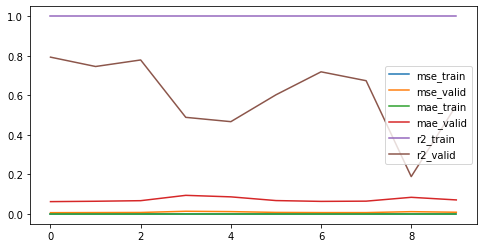

In [7]:
ax = pd.DataFrame(default_model_scores_ori).plot(figsize=(8,4))

### Hyperparameter Optimization with Time Series Cross Validation
- Bayesian optimization
- https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html

In [8]:
# search space for the hyperparameters
space = [Integer(1, 50, name='max_depth'),
         Integer(2, 200, name='min_samples_split'),
         Integer(1, 200, name='min_samples_leaf')]

Optimal point: [6, 45, 167]
Function value at optimal point: 0.004863696588795006


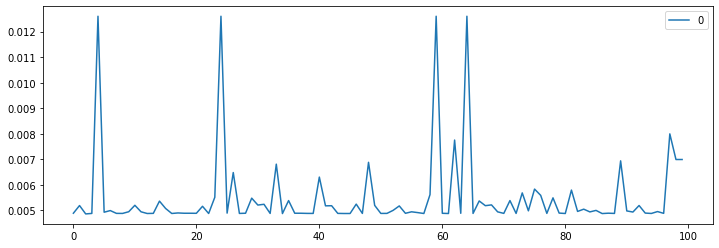

In [9]:
# objective function to minimize
def objective(params):
    max_depth, min_samples_split, min_samples_leaf = params
    model = ml_algorithm(max_depth=int(max_depth), min_samples_split=int(min_samples_split), min_samples_leaf=int(min_samples_leaf), random_state=23)
    scores = cross_validation(data_set, model, 'tau_target_ori')
    return np.mean(scores['mse_valid'])

# perform the optimization
result = gp_minimize(objective, space, n_calls=100, n_random_starts=20, acq_func='EI', acq_optimizer='auto', random_state=23, n_jobs=-1)

# optimal point and function value
print('Optimal point:', result.x)
print('Function value at optimal point:', result.fun)
ax = pd.DataFrame(result.func_vals).plot(figsize=(12,4))

### Time Series Cross Validation on Optimal Model

In [10]:
# ---------------- config opt model -----------------
opt_model_ori = ml_algorithm(max_depth=6, min_samples_split=45, min_samples_leaf=167, random_state=23)

In [11]:
opt_model_ori_tscv_scores = cross_validation(data_set, opt_model_ori, 'tau_target_ori')
opt_model_ori_tscv_scores = pd.DataFrame(opt_model_ori_tscv_scores)
display(opt_model_ori_tscv_scores)
display(opt_model_ori_tscv_scores.describe())

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
0,0.003529,0.002731,0.046572,0.041258,0.855783,0.910614
1,0.003369,0.003877,0.045186,0.049134,0.874084,0.856083
2,0.003184,0.004913,0.043998,0.056753,0.884050,0.851805
3,0.003345,0.009642,0.045204,0.082523,0.888135,0.632987
4,0.003940,0.007702,0.049200,0.073463,0.867641,0.648745
5,0.004456,0.003222,0.052861,0.044252,0.847578,0.832365
6,0.004365,0.003007,0.052305,0.044386,0.846572,0.874859
7,0.004195,0.002581,0.051285,0.040404,0.852797,0.874584
8,0.003893,0.007522,0.048904,0.071111,0.858369,0.466482
9,0.004268,0.003440,0.051628,0.046663,0.840623,0.816199


,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.003854,0.004864,0.048714,0.054995,0.861563,0.776472
std,0.000468,0.002513,0.003284,0.015257,0.016278,0.144149
min,0.003184,0.002581,0.043998,0.040404,0.840623,0.466482
25%,0.003409,0.003060,0.045546,0.044285,0.848883,0.690608
50%,0.003916,0.003659,0.049052,0.047898,0.857076,0.842085
75%,0.004250,0.006870,0.051542,0.067521,0.872473,0.869959
max,0.004456,0.009642,0.052861,0.082523,0.888135,0.910614


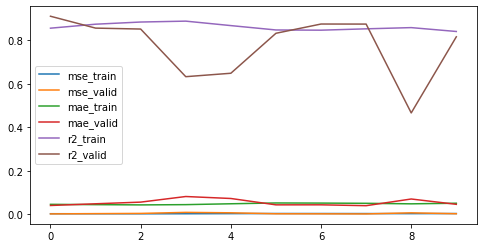

In [12]:
ax = opt_model_ori_tscv_scores[['mse_train', 'mse_valid', 'mae_train', 'mae_valid', 'r2_train', 'r2_valid']].plot(figsize=(8,4))

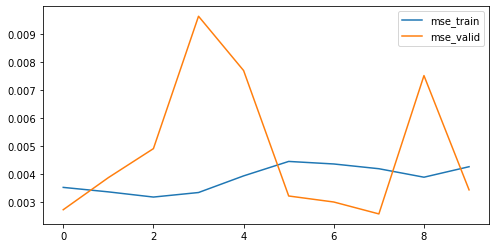

In [13]:
ax = opt_model_ori_tscv_scores[['mse_train', 'mse_valid']].plot(figsize=(8,4))

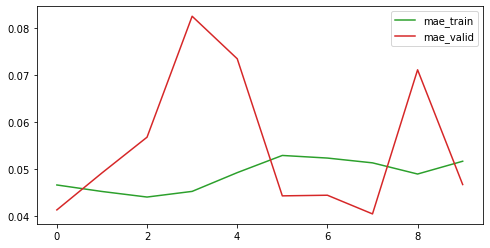

In [14]:
ax = opt_model_ori_tscv_scores[['mae_train', 'mae_valid']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

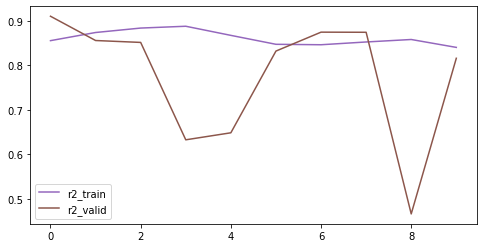

In [15]:
ax = opt_model_ori_tscv_scores[['r2_train', 'r2_valid']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

### Model Performance on Test Set

In [16]:
opt_model_ori_test_scores = performance_test_shifted(data_set, opt_model_ori, 'tau_target_ori')
opt_model_ori_test_scores = pd.DataFrame(opt_model_ori_test_scores)
display(opt_model_ori_test_scores)
display(opt_model_ori_test_scores.describe())

,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
0,0.003381,0.003924,0.045242,0.049393,0.873063,0.854316,0.366445,0.389801
1,0.003370,0.004945,0.045156,0.057282,0.876733,0.850841,0.425448,0.397859
2,0.003342,0.009552,0.045258,0.082196,0.887913,0.636386,0.330819,0.392786
3,0.003984,0.007537,0.049699,0.072773,0.864491,0.656260,0.286654,0.350998
4,0.004318,0.003191,0.051966,0.044013,0.851502,0.833974,0.281294,0.283931
5,0.004206,0.003060,0.051111,0.044659,0.851507,0.872634,0.288558,0.271198
6,0.004112,0.002640,0.050684,0.040864,0.854066,0.871713,0.291026,0.286843
7,0.003952,0.007771,0.049571,0.072505,0.857201,0.448846,0.199579,0.262101
8,0.004206,0.003381,0.051140,0.046402,0.847544,0.819357,0.245124,0.233165
9,0.004126,0.003524,0.050677,0.048484,0.842229,0.830629,0.245513,0.217231


,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.003900,0.004953,0.049050,0.055857,0.860625,0.767496,0.296046,0.308591
std,0.000384,0.002435,0.002732,0.014663,0.014546,0.140868,0.064764,0.068416
min,0.003342,0.002640,0.045156,0.040864,0.842229,0.448846,0.199579,0.217231
25%,0.003523,0.003238,0.046336,0.045095,0.851503,0.697034,0.254458,0.264375
50%,0.004048,0.003724,0.050188,0.048939,0.855634,0.832302,0.287606,0.285387
75%,0.004186,0.006889,0.051004,0.068699,0.870920,0.853448,0.320871,0.380100
max,0.004318,0.009552,0.051966,0.082196,0.887913,0.872634,0.425448,0.397859


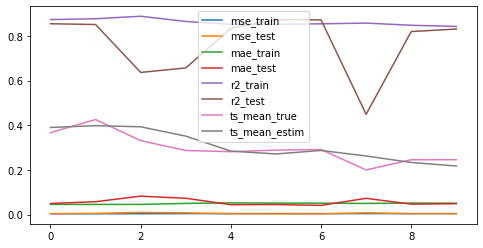

In [17]:
ax = opt_model_ori_test_scores.plot(figsize=(8,4))

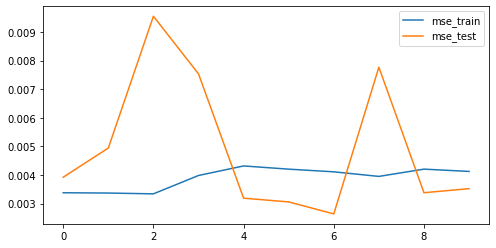

In [18]:
ax = opt_model_ori_test_scores[['mse_train', 'mse_test']].plot(figsize=(8,4))

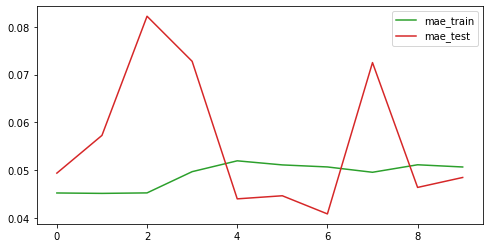

In [19]:
ax = opt_model_ori_test_scores[['mae_train', 'mae_test']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

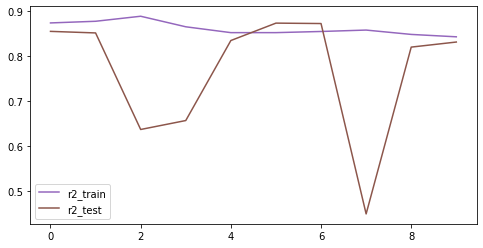

In [20]:
ax = opt_model_ori_test_scores[['r2_train', 'r2_test']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

(0.2, 0.45)

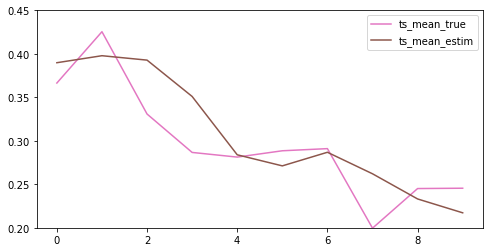

In [21]:
ax = opt_model_ori_test_scores[['ts_mean_true', 'ts_mean_estim']].plot(figsize=(8,4), color=['#e377c2', '#8c564b'])
plt.ylim([0.2,0.45])

### Data for Storage

In [22]:
results_ori = {'Model': [opt_model_ori],
            'fc_horizon': 0,
            'vif': [vif],
            'mse_tscv_t': [opt_model_ori_tscv_scores.mse_train.mean()],
            'mse_tscv_v': [opt_model_ori_tscv_scores.mse_valid.mean()],
            'mse_train': [opt_model_ori_test_scores.mse_train.mean()],
            'mse_test': [opt_model_ori_test_scores.mse_test.mean()],
               
            'mae_tscv_t': [opt_model_ori_tscv_scores.mae_train.mean()],
            'mae_tscv_v': [opt_model_ori_tscv_scores.mae_valid.mean()],
            'mae_train': [opt_model_ori_test_scores.mae_train.mean()],
            'mae_test': [opt_model_ori_test_scores.mae_test.mean()],
               
            'r2_tscv_t': [opt_model_ori_tscv_scores.r2_train.mean()],
            'r2_tscv_v': [opt_model_ori_tscv_scores.r2_valid.mean()],
            'r2_train': [opt_model_ori_test_scores.r2_train.mean()],
            'r2_test': [opt_model_ori_test_scores.r2_test.mean()],
               
            'opt_model': [opt_model_ori.get_params()],
            'ts_mean_true': opt_model_ori_test_scores.ts_mean_true.mean(),
            'ts_mean_estim': opt_model_ori_test_scores.ts_mean_estim.mean(),
              }

## ----------------------------------------------------------
## Predicted Target Model (one year forecast horizon)
### Time Series Cross Validation on Default Model

In [23]:
default_model_scores_hor = cross_validation (data_set, default_model, 'tau_target_hor')
pd.DataFrame(default_model_scores_hor).describe()

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.0,10.000000,10.0,10.000000,10.0,10.000000
mean,0.0,0.016199,0.0,0.099232,1.0,0.227167
std,0.0,0.004094,0.0,0.014198,0.0,0.315382
min,0.0,0.012316,0.0,0.086267,1.0,-0.516668
25%,0.0,0.012833,0.0,0.086988,1.0,0.090398
50%,0.0,0.014758,0.0,0.095746,1.0,0.329848
75%,0.0,0.019492,0.0,0.109815,1.0,0.395934
max,0.0,0.023686,0.0,0.126873,1.0,0.557685


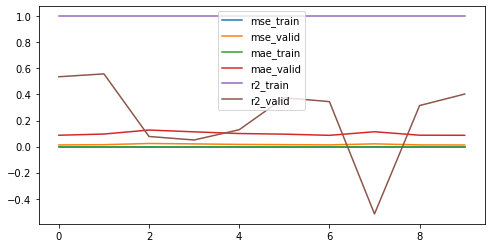

In [24]:
ax = pd.DataFrame(default_model_scores_hor).plot(figsize=(8,4))

### Hyperparameter Optimization with Time Series Cross Validation
- Bayesian optimization
- https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html

Optimal point: [6, 45, 167]
Function value at optimal point: 0.00959322221567092


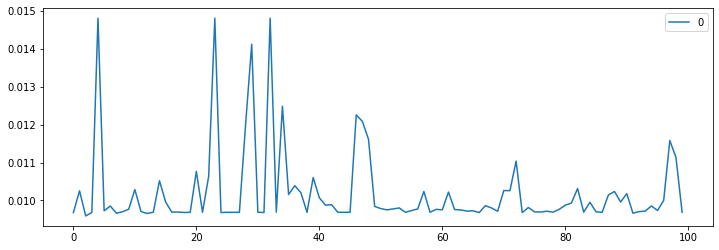

In [25]:
# objective function to minimize
def objective(params):
    max_depth, min_samples_split, min_samples_leaf = params
    model = ml_algorithm(max_depth=int(max_depth), min_samples_split=int(min_samples_split), min_samples_leaf=int(min_samples_leaf), random_state=23)
    scores = cross_validation(data_set, model, 'tau_target_hor')
    return np.mean(scores['mse_valid'])

# perform the optimization
result = gp_minimize(objective, space, n_calls=100, n_random_starts=20, acq_func='EI', acq_optimizer='auto', random_state=23, n_jobs=-1)

# optimal point and function value
print('Optimal point:', result.x)
print('Function value at optimal point:', result.fun)
ax = pd.DataFrame(result.func_vals).plot(figsize=(12,4))

### Time Series Cross Validation on Optimal Model

In [26]:
# ---------------- config opt model -----------------
opt_model_hor = ml_algorithm(max_depth=6, min_samples_split=45, min_samples_leaf=167, random_state=23)

In [27]:
opt_model_hor_tscv_scores = cross_validation(data_set, opt_model_hor, 'tau_target_hor')
opt_model_hor_tscv_scores = pd.DataFrame(opt_model_hor_tscv_scores)
display(opt_model_hor_tscv_scores)
display(opt_model_hor_tscv_scores.describe())

,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
0,0.007456,0.007205,0.069052,0.065400,0.713170,0.735270
1,0.007046,0.009952,0.066471,0.081367,0.737586,0.701507
2,0.007241,0.016567,0.067173,0.107258,0.754306,0.354655
3,0.008345,0.013892,0.072914,0.100571,0.716183,0.355045
4,0.008991,0.009671,0.076059,0.080222,0.688647,0.493241
5,0.009131,0.006792,0.076856,0.065652,0.675864,0.712493
6,0.008922,0.006073,0.075666,0.061363,0.682986,0.694816
7,0.007966,0.013546,0.070751,0.097429,0.704614,0.020523
8,0.007807,0.006352,0.069959,0.063934,0.704107,0.659038
9,0.007524,0.005881,0.068518,0.061435,0.700641,0.714906


,mse_train,mse_valid,mae_train,mae_valid,r2_train,r2_valid
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.008043,0.009593,0.071342,0.078463,0.707810,0.544149
std,0.000764,0.003846,0.003807,0.017693,0.024099,0.236439
min,0.007046,0.005881,0.066471,0.061363,0.675864,0.020523
25%,0.007473,0.006462,0.068651,0.064301,0.691646,0.389594
50%,0.007887,0.008438,0.070355,0.072937,0.704361,0.676927
75%,0.008778,0.012648,0.074978,0.093413,0.715430,0.709747
max,0.009131,0.016567,0.076856,0.107258,0.754306,0.735270


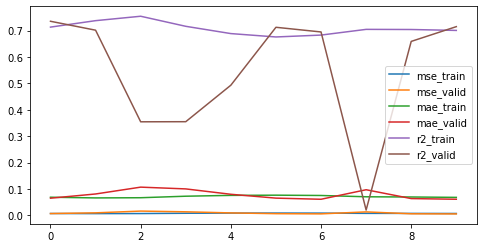

In [28]:
ax = opt_model_hor_tscv_scores[['mse_train', 'mse_valid', 'mae_train', 'mae_valid', 'r2_train', 'r2_valid']].plot(figsize=(8,4))

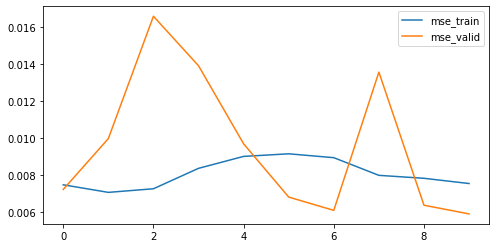

In [29]:
ax = opt_model_hor_tscv_scores[['mse_train', 'mse_valid']].plot(figsize=(8,4))

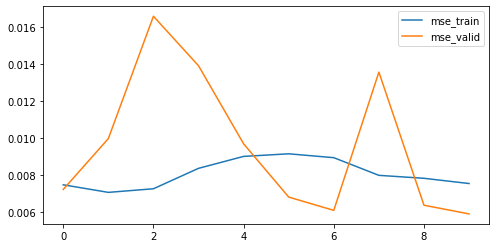

In [30]:
ax = opt_model_hor_tscv_scores[['mse_train', 'mse_valid']].plot(figsize=(8,4))

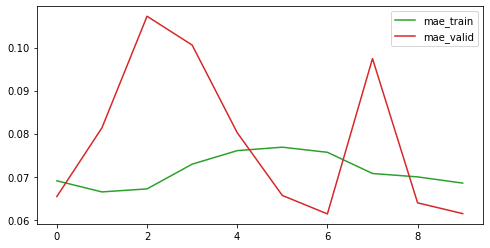

In [31]:
ax = opt_model_hor_tscv_scores[['mae_train', 'mae_valid']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

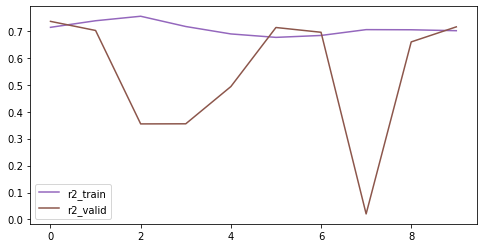

In [32]:
ax = opt_model_hor_tscv_scores[['r2_train', 'r2_valid']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

### Model Performance on Test Set

In [33]:
opt_model_hor_test_scores = performance_test_shifted(data_set, opt_model_hor, 'tau_target_hor')
opt_model_hor_test_scores = pd.DataFrame(opt_model_hor_test_scores)
display(opt_model_hor_test_scores)
display(opt_model_hor_test_scores.describe())

,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
0,0.007208,0.009748,0.067329,0.080671,0.729774,0.707624,0.429797,0.390125
1,0.007254,0.016430,0.067425,0.107084,0.752842,0.359992,0.335499,0.419912
2,0.008120,0.013767,0.071603,0.099419,0.719278,0.360858,0.293080,0.385196
3,0.008805,0.009405,0.075274,0.078778,0.692716,0.507167,0.287144,0.347157
4,0.008935,0.007025,0.075834,0.067751,0.680371,0.702611,0.295090,0.309176
5,0.008684,0.006250,0.074664,0.062111,0.688228,0.685920,0.292463,0.306057
6,0.008382,0.016080,0.072800,0.107264,0.692711,-0.162686,0.205042,0.304719
7,0.008360,0.006600,0.072738,0.065445,0.691107,0.645693,0.247086,0.257555
8,0.007576,0.005877,0.068940,0.061459,0.706311,0.715092,0.248710,0.238242
9,0.007313,0.019761,0.067481,0.123196,0.704974,-0.059344,0.342639,0.227262


,mse_train,mse_test,mae_train,mae_test,r2_train,r2_test,ts_mean_true,ts_mean_estim
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.008064,0.011095,0.071409,0.085318,0.705831,0.446293,0.297655,0.318540
std,0.000673,0.005030,0.003381,0.022273,0.022321,0.324620,0.062015,0.066329
min,0.007208,0.005877,0.067329,0.061459,0.680371,-0.162686,0.205042,0.227262
25%,0.007379,0.006706,0.067845,0.066022,0.691508,0.360208,0.258318,0.269346
50%,0.008240,0.009577,0.072171,0.079725,0.698845,0.576430,0.292772,0.307617
75%,0.008609,0.015502,0.074198,0.105168,0.716036,0.698438,0.325397,0.375687
max,0.008935,0.019761,0.075834,0.123196,0.752842,0.715092,0.429797,0.419912


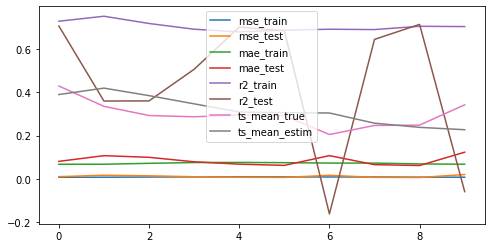

In [34]:
ax = opt_model_hor_test_scores.plot(figsize=(8,4))

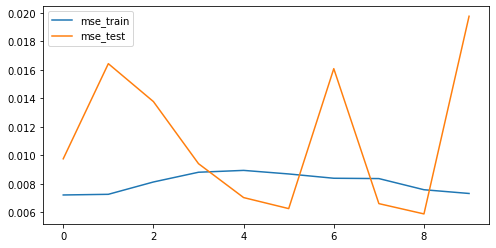

In [35]:
ax = opt_model_hor_test_scores[['mse_train', 'mse_test']].plot(figsize=(8,4))

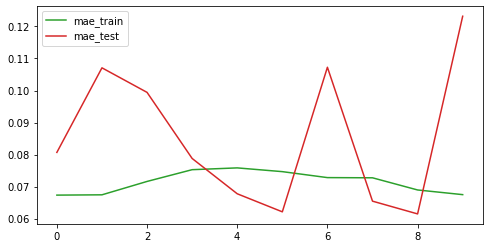

In [36]:
ax = opt_model_hor_test_scores[['mae_train', 'mae_test']].plot(figsize=(8,4), color=['#2ca02c', '#d62728'])

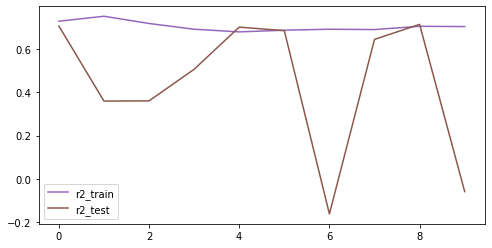

In [37]:
ax = opt_model_hor_test_scores[['r2_train', 'r2_test']].plot(figsize=(8,4), color=['#9467bd', '#8c564b'])

(0.2, 0.45)

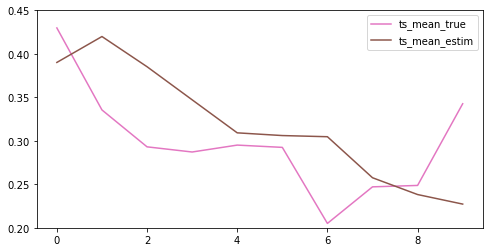

In [38]:
ax = opt_model_hor_test_scores[['ts_mean_true', 'ts_mean_estim']].plot(figsize=(8,4), color=['#e377c2', '#8c564b'])
plt.ylim([0.2,0.45])

### Data for Storage

In [39]:
results_hor = {'Model': [opt_model_ori],
            'fc_horizon': 1,
            'vif': [vif],
            'mse_tscv_t': [opt_model_hor_tscv_scores.mse_train.mean()],
            'mse_tscv_v': [opt_model_hor_tscv_scores.mse_valid.mean()],
            'mse_train': [opt_model_hor_test_scores.mse_train.mean()],
            'mse_test': [opt_model_hor_test_scores.mse_test.mean()],
               
            'mae_tscv_t': [opt_model_hor_tscv_scores.mae_train.mean()],
            'mae_tscv_v': [opt_model_hor_tscv_scores.mae_valid.mean()],
            'mae_train': [opt_model_hor_test_scores.mae_train.mean()],
            'mae_test': [opt_model_hor_test_scores.mae_test.mean()],
               
            'r2_tscv_t': [opt_model_hor_tscv_scores.r2_train.mean()],
            'r2_tscv_v': [opt_model_hor_tscv_scores.r2_valid.mean()],
            'r2_train': [opt_model_hor_test_scores.r2_train.mean()],
            'r2_test': [opt_model_hor_test_scores.r2_test.mean()],
               
            'opt_model': [opt_model_hor.get_params()],
            'ts_mean_true': opt_model_hor_test_scores.ts_mean_true.mean(),
            'ts_mean_estim': opt_model_hor_test_scores.ts_mean_estim.mean(),
              }

## Safe to Excel

In [41]:
results = pd.concat([pd.DataFrame(results_ori), pd.DataFrame(results_hor)])

display(results)

storage_name = filename + '_' + vif + '_' + str(datetime.today().day) + '.xlsx'

pd.DataFrame(results).to_excel(path + 'artifacts' + slash + storage_name, index=None)

,Model,fc_horizon,vif,mse_tscv_t,mse_tscv_v,mse_train,mse_test,mae_tscv_t,mae_tscv_v,mae_train,mae_test,r2_tscv_t,r2_tscv_v,r2_train,r2_test,opt_model,ts_mean_true,ts_mean_estim
0,"DecisionTreeRegressor(max_depth=6, min_samples_leaf=167, min_samples_split=45,\n random_state=23)",0,vif_5,0.003854,0.004864,0.003900,0.004953,0.048714,0.054995,0.049050,0.055857,0.861563,0.776472,0.860625,0.767496,"{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 167, 'min_samples_split': 45, 'min_weight_fraction_leaf': 0.0, 'random_state': 23, 'splitter': 'best'}",0.296046,0.308591
0,"DecisionTreeRegressor(max_depth=6, min_samples_leaf=167, min_samples_split=45,\n random_state=23)",1,vif_5,0.008043,0.009593,0.008064,0.011095,0.071342,0.078463,0.071409,0.085318,0.707810,0.544149,0.705831,0.446293,"{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 167, 'min_samples_split': 45, 'min_weight_fraction_leaf': 0.0, 'random_state': 23, 'splitter': 'best'}",0.297655,0.318540
